In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from urllib.request import urlopen
import json
from credentials import *
from entsoe import EntsoePandasClient
from entsoe.mappings import lookup_area
from pycaret.time_series import *
mpl.rcParams['figure.dpi'] = 150


In [2]:
country_code = 'DE'

df_countries = pd.read_csv('../countries.csv', index_col = 'country')

lat = df_countries.loc[country_code].latitude.astype('str')
lon = df_countries.loc[country_code].longitude.astype('str')

In [3]:
# Get weather forecast

key = get_weather_key()
q = lat+','+lon

url = 'http://api.weatherapi.com/v1/forecast.json?key=' + key \
       + '&q=' + q \
       + '&days=3&aqi=no&alerts=no'

response = urlopen(url)

data_json = json.loads(response.read())
df_weather = pd.json_normalize(data_json['forecast']['forecastday'], 'hour')
df_weather.set_index(pd.DatetimeIndex(pd.to_datetime(df_weather['time'])), inplace = True)


In [362]:
# Get historical weather

url = 'https://api.weatherapi.com/v1/history.json?key=' + key \
      + '&q=' + q \
      + '&dt=2022-07-02&end_dt=2022-07-08'

response = urlopen(url)
data_json = json.loads(response.read())
df_weather_hist = pd.json_normalize(data_json['forecast']['forecastday'], 'hour')
df_weather_hist.set_index(pd.DatetimeIndex(pd.to_datetime(df_weather_hist['time'])), inplace = True)

In [363]:
# Get energy data
area = lookup_area(country_code)

client = EntsoePandasClient(api_key=get_token())
end = pd.Timestamp.now(tz=area.tz) # - pd.DateOffset(days=10)
start = end - pd.DateOffset(days = 8)
%time df_energy = client.query_generation(area, start=start,end=end, nett = True, psr_type=None)
df_energy.set_index(df_energy.index.tz_localize(None), inplace = True)
df_energy = df_energy.resample('H').mean()


Wall time: 7.22 s


In [364]:
# Join energy and weather data

df_join = df_energy.join(df_weather_hist, how = 'inner')

df_join.head()

,Biomass,Fossil Brown coal/Lignite,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,...,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,condition.text,condition.icon,condition.code
2022-07-02 00:00:00,4126.00,12378.25,4121.50,7499.75,8.0,21.0,970.25,1660.50,207.00,4018.50,...,0,0,0,10.0,6.0,11.2,18.0,Clear,//cdn.weatherapi.com/weather/64x64/night/113.png,1000
2022-07-02 01:00:00,4121.50,12341.00,3658.25,6783.75,8.0,21.0,849.25,1668.75,168.50,4018.00,...,0,0,0,10.0,6.0,10.4,16.8,Clear,//cdn.weatherapi.com/weather/64x64/night/113.png,1000
2022-07-02 02:00:00,4136.00,12010.00,3319.25,6313.75,8.0,21.0,-153.25,1702.25,190.75,4019.00,...,0,0,0,10.0,6.0,9.7,15.6,Clear,//cdn.weatherapi.com/weather/64x64/night/113.png,1000
2022-07-02 03:00:00,4140.75,11705.25,2949.50,6120.25,8.0,21.0,-669.25,1697.00,173.75,4022.75,...,0,0,0,10.0,6.0,8.9,14.4,Clear,//cdn.weatherapi.com/weather/64x64/night/113.png,1000
2022-07-02 04:00:00,4130.00,11679.00,2591.25,6090.25,8.0,21.0,-196.25,1672.50,71.00,4028.00,...,0,0,0,10.0,6.0,7.9,12.7,Clear,//cdn.weatherapi.com/weather/64x64/night/113.png,1000


In [365]:
df_join.columns

Index(['Biomass', 'Fossil Brown coal/Lignite', 'Fossil Gas',
       'Fossil Hard coal', 'Fossil Oil', 'Geothermal', 'Hydro Pumped Storage',
       'Hydro Run-of-river and poundage', 'Hydro Water Reservoir', 'Nuclear',
       'Other', 'Other renewable', 'Solar', 'Waste', 'Wind Offshore',
       'Wind Onshore', 'time_epoch', 'time', 'temp_c', 'temp_f', 'is_day',
       'wind_mph', 'wind_kph', 'wind_degree', 'wind_dir', 'pressure_mb',
       'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud',
       'feelslike_c', 'feelslike_f', 'windchill_c', 'windchill_f',
       'heatindex_c', 'heatindex_f', 'dewpoint_c', 'dewpoint_f',
       'will_it_rain', 'chance_of_rain', 'will_it_snow', 'chance_of_snow',
       'vis_km', 'vis_miles', 'gust_mph', 'gust_kph', 'condition.text',
       'condition.icon', 'condition.code'],
      dtype='object')

In [366]:
columns = ['Solar', 'temp_c', 'is_day', 'wind_kph',
           'dewpoint_c', 'cloud', 'humidity']

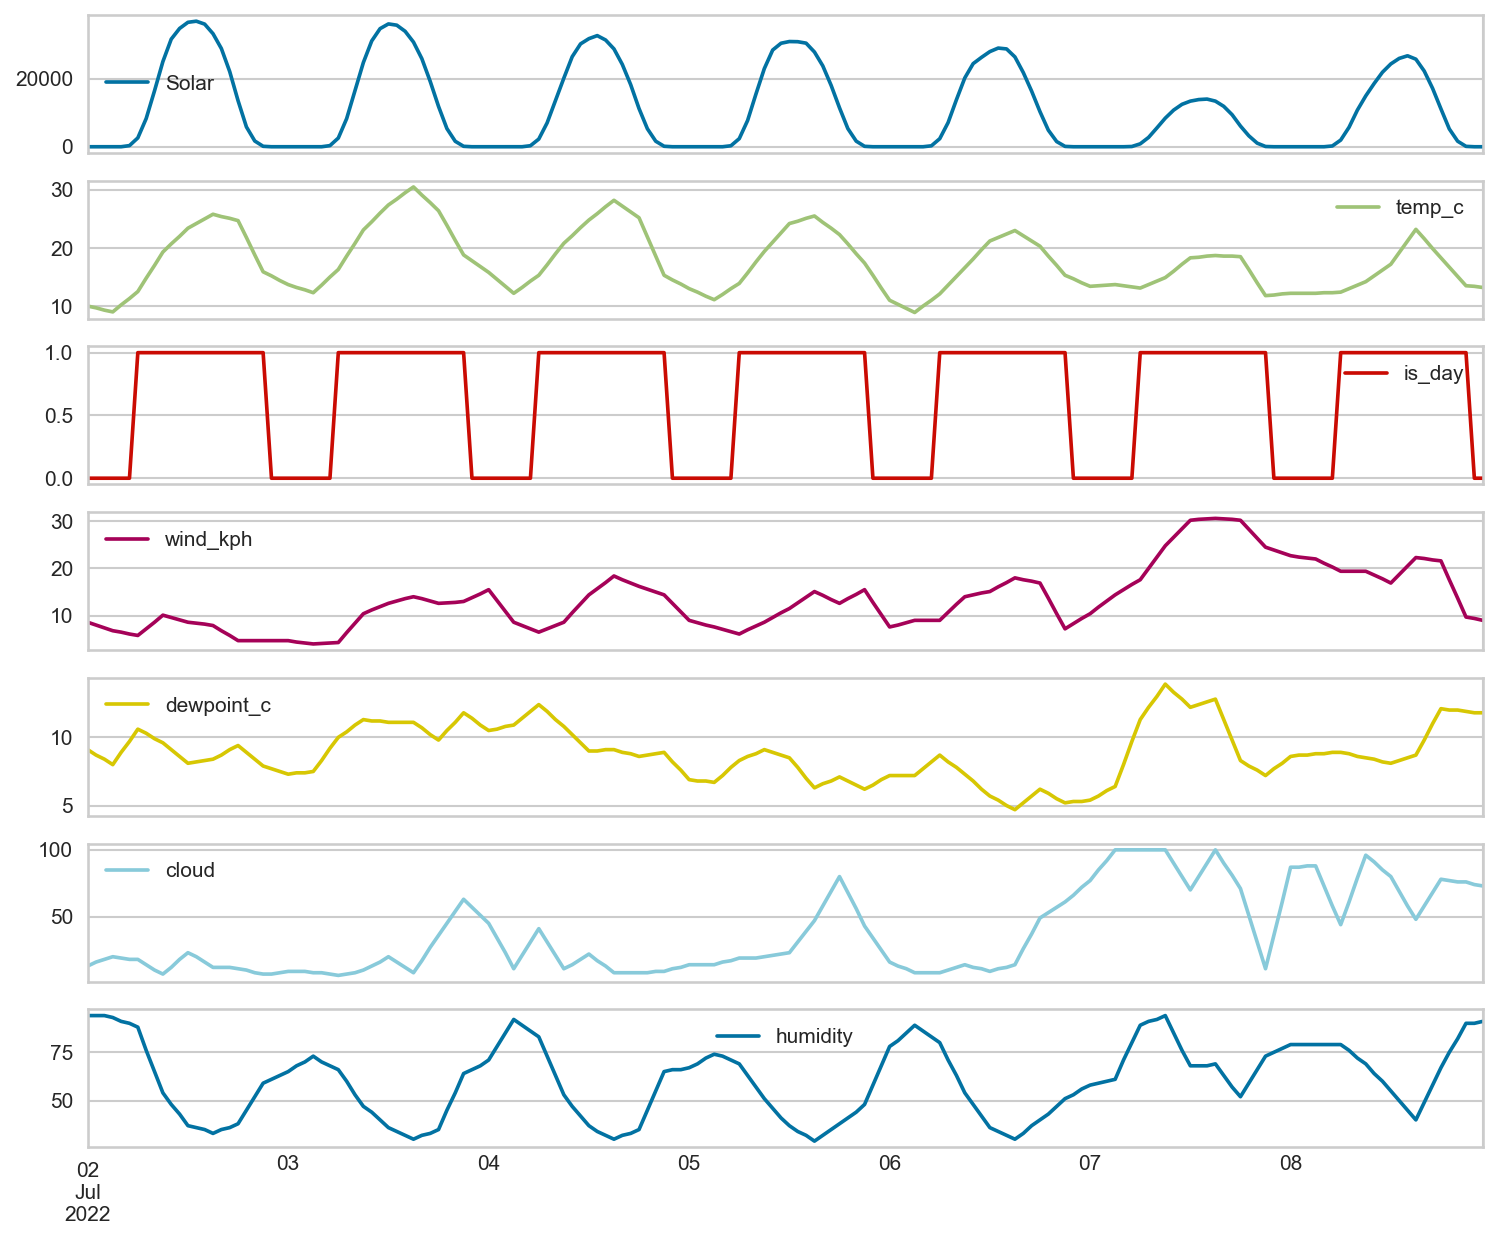

In [367]:
df_join[columns].plot(subplots = True, figsize = (12,10))
plt.show()